# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
plt.style.use('ggplot')


### 1) Importer le tableau de données dans un dataframe 

Il est interessant ici d'ouvrir au préalable le fichier csv avec un logiciel comme<br>
<b>notepad++</b> afin de voir les specificités du document (separateur, etc....).

In [2]:
# Import du dataframe "data.csv"
filename = 'data.csv'
df = pd.read_csv(filename, sep=',', decimal=',')


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [3]:
# methode: avec shape
message = 'methode: nombre d\'observations du dataset {} \n'
print(message.format(df.shape[0]))


methode: nombre d'observations du dataset 9582 



In [4]:
# Calculons la proportion de valeurs manquantes dans chacune des columnes
print('proportion des valeurs manquantes dans chacune des columnes en %: \n')
print(df.isnull().mean()*100)


proportion des valeurs manquantes dans chacune des columnes en %: 

Entreprise      0.177416
Metier          0.198288
Technologies    0.000000
Diplome         0.000000
Experience      0.981006
Ville           0.000000
dtype: float64


<br> Concernant les valeurs manquantes, je constate que les variables categorielles <b> Entreprise</b>, <b>Metier</b> en contiennent approximativement et respectivement <b>0.17%</b> et <b>0.18%</b> tandis que la variable numerique <b>Experience</b> en contient moins de <b>1%</b>.
<br> Ces donnees manquantes sont assez rares (moins de 1%) en general, le dataset est donc exploitable et on peut remplacer ces valeurs manquantes par diverses méthodes (moyenne, medianne, mode (pour les variables categorielles)

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [5]:
def making_imputation(dataframe, value, method):
    """ remplacer les valeurs manquantes
    Parametres
    ----------
    dataframe : dataframe avec valeurs manquantes
    value: metiers dans Metier (Data scientist,etc ...)
    method : methode de remplacement (mean, mediane etc..)
    Retour
    -------
    df : return new dataframe with replaced values
    """

    # faire une copie du dataset
    df = dataframe.copy()
    # faire des verifications quant aux entrees
    message1 = 'valeur non presente dans Experience'
    message2 = 'methode inconnue'
    assert value in np.unique(df.Metier.dropna()), message1
    assert method in ['mean', 'median'], message2
    # rechercher les indices qui satisfassent la condition
    indices = np.where((df.Metier == value) & (df.Experience.isnull()))[0]
    # la methode de remplacement
    if method == 'mean':
        moyenne = round(
            np.mean(df.Experience.iloc[np.where(df.Metier == value)]), 2
        )
        df.loc[indices, 'Experience'] = moyenne
    elif method == 'median':
        moyenne = round(
            np.mean(df.Experience.iloc[np.where(df.Metier == value)]), 2
        )
        df.loc[indices, 'Experience'] = moyenne
    return df


# Remplacer les valeurs manquantes pour les data scientists par la mediane
df = making_imputation(df, 'Data scientist', 'median')
# Remplacer les valeurs manquantes pour les data engineers par la moyenne
df = making_imputation(df, 'Data engineer', 'mean')


La méthode que j'ai employee ici, consiste d'abord a detecter <b> les indices </b> du dataset correspondant aux differents emplois qu'on recherche ici, à savoir <b> data scientist </b> et <b> data engineers </b>.
<br> Ensuite nous allons proceder à la modification des <b> NaN </b> presents à ces ligne par les valeurs demandées.
<br> J'utiliserai ici compte tenu de la taille du dataset (moins de 10.000 lignes) les fonctions de <b>numpy</b> qui donnent de meilleurs performances comparativement à celles de <b>pandas</b>.

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [6]:
# Calcul des annees d'experiences de chacun des profils
print(
    'Moyenne des experiences des differents metiers \n {}'.format(
        round(df.groupby('Metier')['Experience'].mean(), 2)
    )
)


Moyenne des experiences des differents metiers 
 Metier
Data architecte        3.00
Data engineer          2.98
Data scientist         2.24
Lead data scientist    3.97
Name: Experience, dtype: float64


<b> Le data scientist </b> a en moyenne <b>3.0 annees </b> d'experiences. <br>
<b> Le lead data scientist </b> a en moyenne <b>3.97 annees </b> d'experiences. <br>
<b> Le data engineer </b> a en moyenne <b>2.98 annees </b> d'experiences.

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

Text(0.5, 1.0, "Annee d'experiences de divers acteurs de la data")

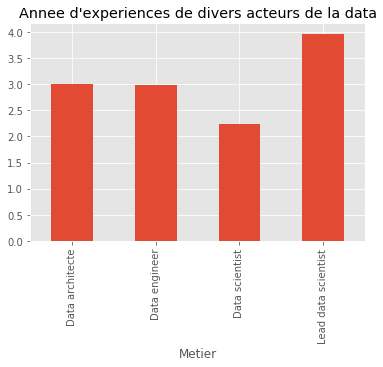

In [7]:
df.groupby('Metier')['Experience'].mean().plot(kind='bar')
plt.title('Annee d\'experiences de divers acteurs de la data')


### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

Verifions s'il reste encore des <b>NaN</b> dans la variable <b>Experience</b>

In [8]:
# Verifions s'il reste encore des NaN dans experience
df.isnull().mean()*100


Entreprise      0.177416
Metier          0.198288
Technologies    0.000000
Diplome         0.000000
Experience      0.438322
Ville           0.000000
dtype: float64

Il reste encore <b>0.43%</b> de NaN dans experience, certainement du aux valeurs dans Lead data scientist et lead architect qu'on a pas modifié.
<br> Afin de transformer la variable categorielle, nous allons aussi proceder à l'imputation de ces <b>NaN</b> avec
la mediane, plus robuste aux valeurs abberantes

In [9]:
# Remplacer les valeurs manquantes pour les data architectes par la mediane
df = making_imputation(df, 'Lead data scientist', 'median')
# Remplacer les valeurs manquantes pour les lead data scientist par la moyenne
df = making_imputation(df, 'Data architecte', 'median')


<b> Explication de la methode de transformation </b>

La categorisation d'une variabe continue s'accomapagne toujours d'une perte d'informations mais elle peut accelerer et ameliorer les performances du modèle predictif.
<br> J'envisageais deux methodes, en utilisant les fonctions <b>cut</b> et <b>qcut</b>.
<br> La fonction qcut est base sur les quantiles et subdivise la variable continue en clusters irregulierement espacé mais contenant a peu près le meme nombre d'individu.
<br> La méthode cut quant à elle créer des clusters successifs mais ne contenant pas forcement le meme nombre d'individus. Cette méthode nous parait plus réaliste.
<br> Une dernière méthode consisterait ici à utiliser des connaissances à priori pour effectuer cette classfication.
    <br> Nous choisissons ici d'uliser la méthode <b> qcut </b> de pandas plus adapté à notre problematique;

In [10]:
# Realisons ala categorisation avec la methode cut
df['Exp_label'] = df.groupby('Metier')['Experience'].apply(
    lambda x: pd.cut(
        x, bins=4, labels=["debutant", "confirme", "avance", "expert"]
    )
)


Plutot que de categoriser ici de manière generale, nous allons créer les categories en fonctions du métier.

Text(0.5, 1.0, 'repartition des categories')

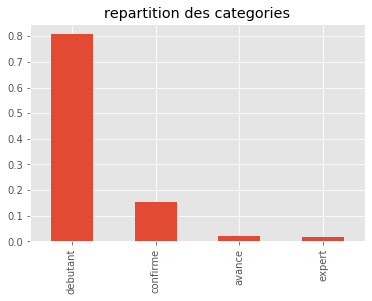

In [11]:
(df.Exp_label.value_counts() / df.shape[0]).plot(kind="bar")
plt.title('repartition des categories')

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

Listons l'ensemble des technologies utilisées par l'ensemble des candidats

Regardons si sur chaque ligne, chaque observation ne contient pas une technoogie en double ce qui peut fausser le calcul du decompte.
<br> On se sert de set pour faire le compte des technoogies uniques et nous verifions si ce compte est egale à celle de la liste de depart si oui il n'ya pas de double sinon il y'en a

#### Visualisons la liste unique de l'ensemble des technologies

Plusieurs choses sont a noter après visualisation de la colonne <b> Technologie</b> : 
<br> L'anglais n'est pas une technologie donc n'a theoriquement pas sa place parmi les technologies
<br> Des technologies comme <b> Scikit learn </b> sont mentionnés en double a cause des majuscules
<br> Machine learning, big data, map reduce sont des domaines et un paradigme pour le dernier et non pas des technologies au sens propre
<br> <b> Solutions envisagees </b>
<br> <b>1.</b> Mettre en miniscule dans le dataset pour eviter les doublons
<br> <b>2.</b> Pour le listings des 5 technologies les plus utilisees enlever l'Anglais du dataset ainsi que les termes se referant vaguement au domaine (Machine learning, big data, deep learning, scoring).
<br> <b>3.</b> Aussi les termes Hadoop(HDFS) et Hadoop se referent à l'utilisation de la technologie Hadoop. Il y'a donc possibilite de les regrouper. De meme HDFS est le systeme de fichier de Hadoop donc se refère à cette technologie.


In [12]:
# mettre en miniscule les technologies 
df["Technologies_reelles"] = df.Technologies.transform(lambda x: x.lower())
# Remplacons les termes Hadoop(HDFS), HDFS et Hadoop par un unique terme hadoop
df.Technologies_reelles = df.Technologies_reelles.transform(
    lambda x: re.sub("(.+\(hdfs\)|hdfs)", "hadoop", x)
)
# Effacons les termes anglais, machine learning, etc..
df.Technologies_reelles = df.Technologies_reelles.transform(
    lambda x: re.sub(
        "(anglais|big data|machine learning|deep learning|scoring|ai\
         |map-reduce)",
        "",
        x,
    )
)
# creeons un dataset avec chacune des technologies comme columne
mlb = MultiLabelBinarizer()
technologies = pd.DataFrame(
    mlb.fit_transform(df.Technologies_reelles.str.split("/")),
    columns=mlb.classes_,
    index=df.index,
)
# enlever la columne nulle
technologies = technologies.drop("", axis=1)
# verifions si une technologie n'est pas presente 2 fois sur une meme ligne
assert len(np.unique(technologies)) == 2, "presence de doublons"
# mettre en minuscule le texte
technologie_count = technologies.agg("sum").sort_values(ascending=False)


In [13]:
message = 'les 5 technos les plus utilisees sont {}'
print(message.format(technologie_count.index.values[0:5]))

les 5 technos les plus utilisees sont ['python' 'r' 'sql' 'hadoop' 'java']


Cette liste me parait convenable au vu de la definition de technologies et logiciels meme si certains termes peuvent être regrouper ensemble comme python et ses librairies ou la question qu'il aurait à poser est 
qu'es ce la maitrise de python?
<br> Nous allons evoluer avec cette liste

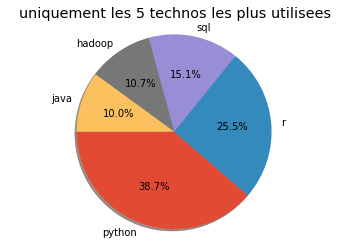

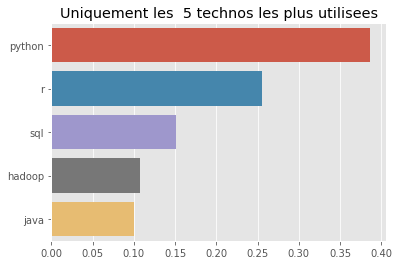

In [14]:
def plotting_most_used_technologies(number, technologie, other_include=True):
    """ tracer un camembert
    Parametres
    ----------
    number : number of technologies
    technologies : liste des technologies
    other_include : inclure oui ou non les autres technos
                    dans le graphique
    Retour
    -------
    retourne un camembert
    """
    n_used_techno_names = np.asarray(technologie.index[:number+1])
    n_used_techno_names = np.append(
        n_used_techno_names, "Autres technos"
    )  # rajouter les autres qu'on a pas comptabiliser
    n_used_techno_count = np.asarray(technologie[: number + 1])
    n_used_techno_count = np.append(
        n_used_techno_count, np.sum(technologie.values[number+1:])
    )
    # tracer du camembert
    if other_include:
        fig1, ax1 = plt.subplots()
        ax1.pie(
            n_used_techno_count,
            labels=n_used_techno_names,
            autopct="%1.1f%%",
            shadow=True,
            startangle=180,
        )
        ax1.axis("equal")
        ax1.set_title(str(number) + " technos les plus utilisees + les autres")
        plt.show()
    else:
        fig2, ax2 = plt.subplots()
        ax2.pie(
            n_used_techno_count[:-2],
            labels=n_used_techno_names[:-2],
            autopct="%1.1f%%",
            shadow=True,
            startangle=180,
        )
        ax2.axis("equal")
        ax2.set_title(
            "uniquement les " + str(number) + " technos les plus utilisees"
        )
        plt.show()


def plot_horizontal_histogram(number, technologie, other_include=True):
    """ tracer un histograme horizontal
    Parametres
    ----------
    number : number of technologies
    technologies : liste des technologies
    other_include : inclure oui ou non les autres technos
                    dans le graphique
    Retour
    -------
    retourne un histogramme horizontal
    """
    n_used_techno_names = np.asarray(technologie.index[: number + 1])
    n_used_techno_names = np.append(
        n_used_techno_names, "Autres technos"
    )  # rajouter les autres qu'on a pas comptabiliser
    n_used_techno_count = np.asarray(technologie[: number + 1])
    n_used_techno_count = np.append(
        n_used_techno_count, np.sum(technologie.values[number+1:])
    )
    if other_include:
        plt.figure(num=0)
        plt.title(
            "Uniquement les  " +
            str(number) +
            " technos les plus utilisees + les autres"
        )
        ax1 = sb.barplot(
            x=n_used_techno_count / np.sum(n_used_techno_count),
            y=n_used_techno_names,
        )
    else:
        plt.figure(num=0)
        plt.title(
            "Uniquement les  " + str(number) + " technos les plus utilisees"
        )
        ax2 = sb.barplot(
            x=n_used_techno_count[:-2] / np.sum(n_used_techno_count[:-2]),
            y=n_used_techno_names[:-2],
        )

# 5 premieres technos  à afficher
NOMBRE_TECHNOS = 5
# inclure oui ou non  les autres technos dans le graphique
INCLUDE_OTHER_TECHNOS = False
# tracé des differents graphiques
plotting_most_used_technologies(
    NOMBRE_TECHNOS, technologie_count, INCLUDE_OTHER_TECHNOS
)
plot_horizontal_histogram(
    NOMBRE_TECHNOS, technologie_count, INCLUDE_OTHER_TECHNOS
)


Conclusion <br>Comme on peut le constater sur le camembert et le barchart <br> Python vient en première position des languages utilisés  par les personnes de la data avec un score de <b>15.3%</b>, suivi de près par le langage R, prisée des statisticiens <b>10.0%</b>, Ensuite viennent des outils de gestion et de requetage de la donnee comme SQL <b>5.9%</b>, Hadoop <b>3.6%</b>. <br> Java lui est moins utilisé comparé à Python et R, cela peut être lié au fait que les outils orientés Machine Learning sont plus rares ou moins vulgarisés (prisés)
<br> Ces scores representent les taux par rapport à l'ensemble des logiciels mentionnes. Nous nous sommes assurés que chaque observation ne contient aucun doublon. <br> Les <b>N+1</b> dernières technologies ont été rangés dans <b> Autres technos </b>.

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#### 8.1 Le clustering que nous allons realisé ici vise à faire apparaitre deux groupes de profils techniques distincts
<br> A cet effet, l'entreprise, le metier, l'experience ne sont pas à mon avis des variables essentielles
<br> Nous allons creer des <b>dummies variables</b> avec la variable <b>Technologies_reelles</b>. A cela nous ajouterons le diplome qui est aussi determinant pour connaitre les profils techniques.
<br> A cet effet, nous utiliserons un autre dataset que nous nomerons <b> profil_technique</b>

In [15]:
# creation de dummies variables avec les metiers
metiers = pd.get_dummies(df.Metier)
# creation de dummies variables avec l'experience
experiences = pd.get_dummies(df.Exp_label)
# concatenons l'ensemble de ces dataframes
profil_technique = pd.concat([technologies, metiers, experiences], axis=1)


Il s'agira ici de remplacer toute les variables categorielles par des variables numeriques avec le one hot encoding. 
On peut supprimer la variable metier pour cette etude, par ce que le metier correspont approximativement a une certaine categorie de competences techniques plus ou moins defini, l'entreprise aussi ne semble pas être une variable pertinente, de meme que la ville ou l'emploi est effectué
Le nombre d annee d experience peut definir un profil technique on va get dummies la variable cree

### Reduction de la dimensionnalite concernant les technologies

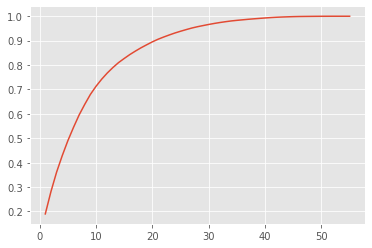

In [16]:
# enregistrer le % de variance explique
percentage_variance_explained = np.array([])
for elt in range(1, profil_technique.shape[1]):
    tsvd = PCA(n_components=elt)
    X = tsvd.fit_transform(profil_technique)
    percentage_variance_explained = np.append(
        percentage_variance_explained,
        tsvd.explained_variance_ratio_[0:elt].sum(),
    )
# tracer une courbe en vue de la selection de variables
plt.plot(
    list(range(1, profil_technique.shape[1])), percentage_variance_explained
)


In [17]:
# recuperer la premiere valeur respectant la condition
number_of_components = (
    np.where(np.asarray(percentage_variance_explained) > 0.95)[0][0] + 1
)
# ne prendre que les "number_of_components" premieres composantes
tsvd = PCA(n_components=number_of_components)
# effectuer une PCA
software_maitrise_to_take = tsvd.fit_transform(profil_technique)
print(
    "pourcentage explique {} \n".format(
        tsvd.explained_variance_ratio_[0:number_of_components].sum()
    )
)


pourcentage explique 0.9516956397736156 



#### Utilisation du KMean

In [18]:
# calcul qualite du clustering avant reduction dimensionnalite
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=10)
preds_kmean = kmeans.fit_predict(profil_technique)
clustering_validity = silhouette_score(profil_technique, preds_kmean)
print("avant reduction dimensionnalite {} \n".format(clustering_validity))

# calcul qualite du clustering apres reduction dimensionnalite
kmeans2 = KMeans(init="k-means++", n_clusters=2, n_init=10)
preds2_kmean = kmeans.fit_predict(software_maitrise_to_take)
clustering_validity2 = silhouette_score(
    software_maitrise_to_take, preds2_kmean
)
print("apres reduction dimensionnalite {} \n".format(clustering_validity2))
# creation d'une columne pour le resultat de prediction
df["profil_technique_kmean"] = preds2_kmean


avant reduction dimensionnalite 0.18625491137989703 

apres reduction dimensionnalite 0.19507330970406628 



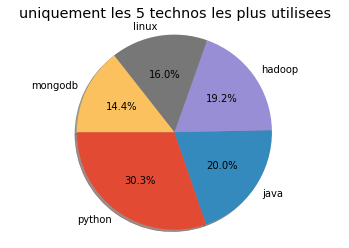

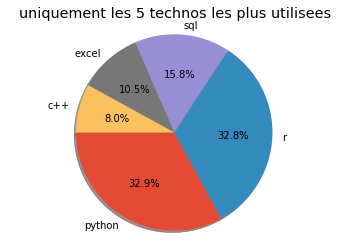

In [19]:
groupe_0_index = df.query("profil_technique_kmean==0").index.values
technos_0 = (
    technologies.iloc[groupe_0_index, :]
    .agg("sum")
    .sort_values(ascending=False)
)
groupe_1_index = df.query("profil_technique_kmean==1").index.values
technos_1 = (
    technologies.iloc[groupe_1_index, :]
    .agg("sum")
    .sort_values(ascending=False)
)
# tracer les 5 technos dominantes du groupe 0
plotting_most_used_technologies(5, technos_0, INCLUDE_OTHER_TECHNOS)
print("================================================ \n")
# tracer les 5 technos dominantes du groupe 1
plotting_most_used_technologies(5, technos_1, INCLUDE_OTHER_TECHNOS)


La qualité du clustering est assez <b> faible </b> et ce malgré la reduction de dimensionnalité qui ameliore ici sensiblement le resultat.


##### Essayons de trouver à quoi corresponde  ces clusters en terme de denomination metier
Je pars de l'hypothèse que le clustering a separer les données en 2 en procedant ainsi,
d'une part les data scientist qui sont charger à partir des données, de les analyser, de les pré traiter et de mettre en place des modèles et d'autres part les autres acteurs de la data à savoir les data architectes et les data engineer qui eux mettre en place des moyens afin d'avoir des données propres, accessibles et exploitables.


In [20]:
# Decouvrons la composition des differents groupes en terme de metier
df.groupby("profil_technique_kmean")["Metier"].value_counts()


profil_technique_kmean  Metier             
0                       Data engineer          2347
                        Data architecte        2123
                        Lead data scientist      25
1                       Data scientist         3865
                        Lead data scientist    1203
Name: Metier, dtype: int64

<b> Notre hypothèse de départ  </b> se voit confirmer
Dans un groupe on a les scientist data scentist et lead data scientist (en majorite) et dans 
l'autre des specialistes de la donnee( data architecte et data engineer)
##### qualite du clustering
La faible qualité du clustering s'explique par  le fait que les clusters crées partagent bon nombre d'elements en commun ( de soft skills) comme <b>python</b> (technologie qui apparait en premier dans les deux groupes) ce qui fait qu'il sont difficilement separable.
Aussi, un data scientist peut très bien s'occuper du recueil de la donnée en utilisant les technologies adequates (SQL etc...) pendant que d'autres ne le font pas, ce qui rend la separation entre ces deux classes très difficile.


### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

##### Creation de variable interessantes
Creer une variable qui va dire si l'individu en question a fait de longues etudes ou pas <br> <b> longue etudes:</b> (BAC+5 et plus).


In [21]:
def higher_ed(value):
    if value == "Phd":
        return "Tres"
    elif value == "Master":
        return "Classique"
    else:
        return "Low"


df["Hautes_etudes"] = df.Diplome.apply(higher_ed)


In [22]:
# recuperons les index avec valeurs manquantes de la columne 'Metier'
metiers_manquant = df[pd.isnull(df.Metier)]
index_metiers_manquants = np.asarray(metiers_manquant.index)


In [23]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """selectionner des columne(s) du dataframe"""

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, attribute_names):
        return self

    def transform(self, X):
        """creer des dummies variables
        Parametres
        ----------
        X : dataframe a utiliser

        Retour
        -------
        dummies_array: dummies array
        """
        encoder = OneHotEncoder()
        dummies_array = pd.get_dummies((X[self.attribute_names]))
        return dummies_array


class MultiLabelDataFrameSelector(BaseEstimator, TransformerMixin):
    """ selection des columne multi label"""

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, attribute_names):
        return self

    def transform(self, X):
        """creer des dummies variables
        Parametres
        ----------
        X : dataframe a utiliser

        Returns
        -------
        dummies_array: dummies array
        """
        mlb = MultiLabelBinarizer()
        dummies_array = pd.DataFrame(
            mlb.fit_transform(X[self.attribute_names].str.split("/")),
            columns=mlb.classes_,
        )
        # enlever la colonne avec '' lie au split
        dummies_array = dummies_array.drop("", axis=1)
        return dummies_array


In [24]:
# definition de quelques fonctions qui me seront utiles
def dummies_categorical_var(single_label_list, multi_label_list, dataframe):
    """creer des dummies variables a partir des variables categorielles
    Parametres
    ----------
    single_label_list : column with unique label per row
    multi_label_list : column with multiple label per row
    dataframe : dataframe with all this columns

    Returns
    -------
    numerique_df : variables numeriques issues des variables categorielles
    metier_manquant : variables numeriques des metiers manquants
    """
    # mettre en place les controles

    # mettre en place des pipelines de donnees en s'appuyant sur le typage
    # canard du Pipeline de sklearn
    pipeline_mono = Pipeline(
        [("one_hot_encoding", DataFrameSelector(single_label_list))]
    )
    pipeline_multi = Pipeline(
        [
            (
                "multi_label_encoding",
                MultiLabelDataFrameSelector(multi_label_list),
            )
        ]
    )

    finale_pipeline = FeatureUnion(
        transformer_list=[
            ("simple_hot_encoding", pipeline_mono),
            ("multi label encoding", pipeline_multi),
        ]
    )

    # convertir les variables en valeurs numeriques
    numerique_df = finale_pipeline.fit_transform(df)

    # Retirons les variables caracteeristiques avec le metier manquant
    metier_manquant = numerique_df[index_metiers_manquants, :]

    # Supprimons ces lignes de notre dataset
    numerique_df = np.delete(numerique_df, index_metiers_manquants, axis=0)

    return numerique_df, metier_manquant


def diviser_dataset(dataframe, numerique_df, ratio_test, column_to_predict):
    """diviser le dataset en un jeu de d'apprentissage
    et un jeu de test.
    Parametres
    ----------
    dataframe : le dataset en question avec des variables categorielles
    dataframe_2 : dataframe avec OneHotEncoding des variables categorielles
    ratio_test : le ratio a attribuer à l'apprentissage
    column_to_predict : columne que l'on veut pouvoir predire

    Returns
    -------
    strat_train_set : jeu d'entrainement
    y_train_set : label d'entrainement
    strat_test_set : jeu de test
    y_test_set : label de test
    """

    # mettre en place les garde fou

    # supprimer de la columne à predire les valeurs NaN
    df_base = df.dropna(subset=[column_to_predict], how="any").reset_index()

    # on va ici diviser le set en 80% pour l'apprentissage et 20% pour le test
    split = StratifiedShuffleSplit(
        n_splits=1, test_size=ratio_test, random_state=42
    )
    for train_index, test_index in split.split(df_base, df_base.Metier):
        strat_train_set = numerique_df[train_index, :]
        strat_test_set = numerique_df[test_index, :]
    strat_train_set = np.column_stack(
        (strat_train_set, df_base.loc[train_index, "Experience"])
    )
    strat_test_set = np.column_stack(
        (strat_test_set, df_base.loc[test_index, "Experience"])
    )
    # recuperons les variables cibles
    y_train_set = df_base.loc[train_index, column_to_predict]
    y_test_set = df_base.loc[test_index, column_to_predict]

    return strat_train_set, y_train_set, strat_test_set, y_test_set


def evaluate_random_forest_performance(grid_search, diff_jeu):
    """evaluer un modele de random forest pour la prediction
       en selectionnant le meilleur jeu d'hyperparametres
       possibles
    Parametres
    ----------
   grid_search : ensemble des parametres grid search
   diff jeu : tuple contenant le jeu d'apprentissage,
              le label d'apprentissage, le jeu de test
              et les labels de test.

    Returns
    -------
    chosen_model : meilleur modele possible
    confusion_matrice : matrice de confusion sur le jeu de test
    """
    model = RandomForestClassifier()
    strat_train_set = diff_jeu[0]  # jeu d'entrainement
    y_train_set = diff_jeu[1]  # label d'entrainement
    strat_train_set = diff_jeu[2]
    y_train_set = diff_jeu[3]
    # faire une recherche des meilleurs hyperparametres avec cv=5
    rf_random = GridSearchCV(
        estimator=model, param_grid=grid_search, cv=5, verbose=2, n_jobs=-1
    )
    # entrainer l'arbre de foret aleatoires
    rf_random.fit(strat_train_set, y_train_set)
    # selectionner le meilleur modele à l'issu du GridSearchCV
    chosen_model = rf_random.best_estimator_
    # score du meilleur modele sur le jeu de validation
    print(
        "score du meilleur modele sur le jeu de validation {}% \n".format(
            rf_random.best_score_ * 100
        )
    )
    # prediction on test_set
    prediction_test_set = chosen_model.predict(strat_test_set)
    print(
        "accuracy on test set : {}% \n".format(
            accuracy_score(y_test_set, prediction_test_set) * 100
        )
    )
    confusion_matrice = confusion_matrix(
        y_test_set, prediction_test_set, labels=list(np.unique(y_test_set))
    )
    return chosen_model, confusion_matrice


def prediction_metier_manquants(
    metier_manquant, attribute_array, chosen_model
):
    """predire les metiers manquants
    Parametres
    ----------
    attribute_array : jeu de donnees ne contenant que les metiers manquants
    chosen_model : modele de prediction charge d'effectuer la prediction

    Returns
    -------
    metiers_a_predire : dataset avec les metiers predits
    """
    metiers_a_predire = metier_manquant.copy()
    # rajout de la columne experience
    attribute_array = np.column_stack(
        (attribute_array, metiers_a_predire.loc[:, "Experience"])
    )
    # prediction avec le modele des classes manquantes
    pred_classes_manquantes = chosen_model.predict(attribute_array)
    # ajouter dans le dataset les metiers predits
    metiers_a_predire.insert(2, "Metiers_predits", pred_classes_manquantes)
    # re ordonner les index du dataset
    metiers_a_predire = metiers_a_predire.reset_index()
    return metiers_a_predire


#### Choix de l'algorithme de classification
Pour le choix de l'algorithme de classification, nous allons ici directement utiliser l'artillerie lourde et 
selectionner un algorithme de type ensembliste type <b> random forest </b>.
<br> Ce choix se justifie notamment par le fait que l'erreur commise lors d'une tache de classification se decompose en deux.
D'une part une <b>erreur bayesienne</b> lie a la distribution des classes et la structure conditionnelle du problème irreductible et une  deuxieme erreur dite <b>ajoutee</b> lié au classifieur qu'on choisie.
Mettre ensemble plusieurs algorithmes de machine learning qui se corrige les uns les autres ou une decision est prise sur l'ensemble des reponses fournie (à la fin pour les <b> random forest </b> et au debut pour les algo du type <b> xgboost </b>) permet d'apporter une robustesse et une justesse supplementaire à la reponse.
<br> <br> Le choix de <b> GridSearchCV </b> par rapport à <b> RandomizedGridSearchCV </b> se justifie ici par la taille du dataset, assez petit et par les capacités de ma machine. 
<br> Bien vrai que le <b> RandomizedGridSearch </b> s'effectue plus rapidement, il donne de moins bon resultats en general sur de petit dataset.
<br> <br> On s'appuie sur le typage <b> canard </b> des transformateurs pipeline pour en creer des customiser
et transformer nos variables categorielle en variable numerique
<br> En effet un tirage purement aleatoire pourrait sous representer ou sur representer une classe dans le jeu d'apprentissage par rapport au jeu de depart ce qui poserait des problemes pour la phase de test.
<br> <br> Dans les differents dataset d'entrainement et de test, nous allons proceder à la transformation des variables categorielles en dummies.
<br> On l'a deja plus haut pour les variables <b> Exp_label</b>, <b>Diplome</b> <b>Metier</b> et <b>Technologies_reelles</b>
<b> La ville et l'entreprise </b> ne definissent à priori pas le metier mais nous allons les laisser dans un premier temps et observer les performances du modèle.

In [25]:
# tester avec un ensemble de variable qui me semblent pertinent
single_frame_selector = [
    "Diplome",
    "Exp_label",
    "Hautes_etudes",
    "profil_technique_kmean",
]
multiple_frame_selector = "Technologies_reelles"
ratio_test = 0.2
numerique_df, metier_manquant = dummies_categorical_var(
    single_frame_selector, multiple_frame_selector, df
)
strat_train_set, y_train_set, strat_test_set, y_test_set = diviser_dataset(
    df, numerique_df, ratio_test, "Metier"
)


#### Premier modèle predictif (Arbre de decision)
Commencons par quelque chose de plus simple de prime abord en
utilisant un arbre de decision


In [26]:
def tree_param_selection(data_set, label_set, nfolds):
    """predire les metiers manquants
    Parametres
    ----------
    data_set : jeu de donnees ne contenant que les metiers manquants
    label_set : modele de prediction charge d'effectuer la prediction
    nfolds : nombre de groupe pour la cross validation
    Returns
    -------
    best_estimator : meilleur estimateur
    """
    # strategie de split
    splitter = ["best", "random"]
    # nombre de feature a considerer à chaque split
    max_features = ["auto", "log2", None]
    # fonction pour mesurer la qualite du split
    criterion = ["gini", "entropy"]

    param_grid = {
        "splitter": splitter,
        "max_features": max_features,
        "criterion": criterion,
    }
    grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid=param_grid,
        cv=nfolds,
        verbose=2,
        n_jobs=-1,
    )
    grid_search.fit(data_set, label_set)
    best_estimator = grid_search.best_estimator_
    return best_estimator

n_folds = 5
tree_clf = tree_param_selection(strat_train_set, y_train_set, n_folds)
# prediction on test_set
prediction_test_set = tree_clf.predict(strat_test_set)
print(
    "accuracy on test set : {}% \n".format(
        accuracy_score(y_test_set, prediction_test_set) * 100
    )
)

# calculer la matrice de confusion
confusion_matrice = confusion_matrix(
    y_test_set, prediction_test_set, labels=list(np.unique(y_test_set))
)
print('columnes matrice confusion {}'.format(list(np.unique(y_test_set))))
print("matrice de confusion \n {} ".format(confusion_matrice))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.3s finished


accuracy on test set : 89.70203868269734% 

columnes matrice confusion ['Data architecte', 'Data engineer', 'Data scientist', 'Lead data scientist']
matrice de confusion 
 [[423   0   0   2]
 [  0 469   0   0]
 [  0   0 717  56]
 [  1   0 138 107]] 


La moyenne des predictions sur le jeu de test est d'environ 89%, ce qui n'est pas mal
pour un simple arbre de decision.
Essayons d'autres modèles comme par exemple un SVM

In [27]:
metiers_a_predire = prediction_metier_manquants(
    metiers_manquant, metier_manquant, tree_clf
)

# avoir un apercu des predictions à effectuer
metiers_a_predire.head(5)


,index,Entreprise,Metier,Metiers_predits,Technologies,Diplome,Experience,Ville,Exp_label,Technologies_reelles,profil_technique_kmean,Hautes_etudes
0,346,Jacobs,NaN,Data engineer,Python/Spark/GNU/Linux,No diploma,2.5,Paris,NaN,python/spark/gnu/linux,0,Low
1,2058,Ball Aerospace,NaN,Data scientist,VBA/Python/Excel/R,Master,15.0,Lyon,NaN,vba/python/excel/r,1,Classique
2,2670,"eHire, LLC",NaN,Data scientist,Java/C/C++/R/Python,Master,1.5,Toulouse,NaN,java/c/c++/r/python,1,Classique
3,2899,Norfolk Southern Corp,NaN,Data scientist,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,NaN,python/tensorflow/scikit-learn//r,1,Tres
4,3346,J.E. Ranta Associates,NaN,Data architecte,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,NaN,cassandra/mongodb/nosql/aws,0,Classique


#### Test du modèle SVM

In [28]:
def svc_param_selection(data_set, label_set, nfolds):
    """predire les metiers manquants
    Parametres
    ----------
    data_set : jeu de donnees ne contenant que les metiers manquants
    label_set : modele de prediction charge d'effectuer la prediction
    nfolds : nombre de groupe pour la cross validation
    Returns
    -------
    best_estimator : meilleur estimateur
    """
    Cs = [0.01, 0.1, 1]
    gammas = [0.01, 0.1, 1]
    kernel = ["rbf", "sigmoid", "linear"]
    param_grid = {"C": Cs, "gamma": gammas, "kernel": kernel}
    grid_search = GridSearchCV(
        estimator=svm.SVC(),
        param_grid=param_grid,
        cv=nfolds,
        verbose=2,
        n_jobs=-1,
    )
    grid_search.fit(data_set, label_set)
    best_estimator = grid_search.best_estimator_
    return best_estimator


modele_svm = svc_param_selection(strat_train_set, y_train_set, n_folds)
# prediction on test_set
prediction_test_set = modele_svm.predict(strat_test_set)
print(
    "accuracy on test set : {}% \n".format(
        accuracy_score(y_test_set, prediction_test_set) * 100
    )
)
# calculer la matrice de confusion
confusion_matrice = confusion_matrix(
    y_test_set, prediction_test_set, labels=list(np.unique(y_test_set))
)
print('columnes matrice confusion {}'.format(list(np.unique(y_test_set))))
print("matrice de confusion \n {} ".format(confusion_matrice))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.4min finished


accuracy on test set : 90.17250392054365% 

columnes matrice confusion ['Data architecte', 'Data engineer', 'Data scientist', 'Lead data scientist']
matrice de confusion 
 [[419   6   0   0]
 [  1 468   0   0]
 [  0   0 754  19]
 [  4   0 158  84]] 


On s'apercoit ici que l'algorithme arrive à relativement bien classer les <b> Data architecte </b> et les <b> Data engineer </b>
<br> Il a cependant plus de mal à distinguer les <b> data scientist </b> des <b> lead data scientist </b>.
<br> Un problème se pose pour les autres corps de metiers comme les <b>Data architecte</b> et les <b> Data engineer </b>.
<br> En effet, il n'est pas precisé si ceux ci sont des <b>lead</b> dans leur domaines c'est à dire possèdent des qualités manageriales, ce qui peut être le cas vu le nombre d'année d'experience de certains d'eux.

In [29]:
metiers_a_predire = prediction_metier_manquants(
    metiers_manquant, metier_manquant, tree_clf
)

# avoir un apercu des predictions à effectuer
metiers_a_predire.head(5)


,index,Entreprise,Metier,Metiers_predits,Technologies,Diplome,Experience,Ville,Exp_label,Technologies_reelles,profil_technique_kmean,Hautes_etudes
0,346,Jacobs,NaN,Data engineer,Python/Spark/GNU/Linux,No diploma,2.5,Paris,NaN,python/spark/gnu/linux,0,Low
1,2058,Ball Aerospace,NaN,Data scientist,VBA/Python/Excel/R,Master,15.0,Lyon,NaN,vba/python/excel/r,1,Classique
2,2670,"eHire, LLC",NaN,Data scientist,Java/C/C++/R/Python,Master,1.5,Toulouse,NaN,java/c/c++/r/python,1,Classique
3,2899,Norfolk Southern Corp,NaN,Data scientist,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,NaN,python/tensorflow/scikit-learn//r,1,Tres
4,3346,J.E. Ranta Associates,NaN,Data architecte,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,NaN,cassandra/mongodb/nosql/aws,0,Classique


#### Utilisation du RANDOM FOREST 
Essayons d'ameliorer les resultats précédents de l'ordre de 90% sur le jeu de test en
privilégiant cette fois ci un algorithme dit ensembliste, le <b> random forest </b>

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=50)]
# Number of features to consider at every split
max_features = ["auto", "log2", None]
# Method of selecting samples for training each tree
bootstrap = [True, False]

grid_search = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "bootstrap": bootstrap,
}

repartition_dataset = (
    strat_train_set,
    y_train_set,
    strat_test_set,
    y_test_set,
)
chosen_model, confusion_matrice = evaluate_random_forest_performance(
    grid_search, repartition_dataset
)
print('columnes matrice confusion {}'.format(list(np.unique(y_test_set))))
print("matrice de confusion \n {} ".format(confusion_matrice))


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 725 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.4min finished


score du meilleur modele sur le jeu de validation 88.7611082070047% 

accuracy on test set : 95.81808677469942% 

columnes matrice confusion ['Data architecte', 'Data engineer', 'Data scientist', 'Lead data scientist']
matrice de confusion 
 [[425   0   0   0]
 [  0 469   0   0]
 [  0   0 747  26]
 [  1   0  53 192]] 


On s'apercoit ici que l'algorithme arrive bien à classer les <b> Data architecte </b> et les <b> Data engineer </b>
<br> Il a cependant plus de mal à distinguer les <b> data scientist </b> des <b> lead data scientist </b> mais moinsque les algorthmes utilisés precedemment à savoir l'arbre de decision et le svm.
<br> Un problème se pose pour les autres corps de metiers comme les <b>Data architecte</b> et les <b> Data engineer </b>.
<br> En effet, il n'est pas precisé si ceux ci sont des <b>lead</b> dans leur domaines c'est à dire possèdent des qualités manageriales, ce qui peut être le cas vu le nombre d'année d'experience de certains d'eux.
<br> Voyons maintenant l'impact  de cette nouvelle variable sur notre <b> matrice de confusion </b> et notre <b> taux de bonne classification </b>.


##### Prediction des valeurs manquantes

In [31]:
metiers_a_predire = prediction_metier_manquants(
    metiers_manquant, metier_manquant, chosen_model
)

# avoir un apercu des predictions à effectuer
metiers_a_predire.head(5)


,index,Entreprise,Metier,Metiers_predits,Technologies,Diplome,Experience,Ville,Exp_label,Technologies_reelles,profil_technique_kmean,Hautes_etudes
0,346,Jacobs,NaN,Data engineer,Python/Spark/GNU/Linux,No diploma,2.5,Paris,NaN,python/spark/gnu/linux,0,Low
1,2058,Ball Aerospace,NaN,Data scientist,VBA/Python/Excel/R,Master,15.0,Lyon,NaN,vba/python/excel/r,1,Classique
2,2670,"eHire, LLC",NaN,Data scientist,Java/C/C++/R/Python,Master,1.5,Toulouse,NaN,java/c/c++/r/python,1,Classique
3,2899,Norfolk Southern Corp,NaN,Data scientist,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,NaN,python/tensorflow/scikit-learn//r,1,Tres
4,3346,J.E. Ranta Associates,NaN,Data architecte,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,NaN,cassandra/mongodb/nosql/aws,0,Classique


### 10) Décrire de façon détaillée les différentes étapes pour mener à bien un projet data complexe.

Dans le cadre d’une campagne de recrutement vous avez reçu un ensemble de cv qui ne sont pas à jour (le poste actuel n’est pas présent). Deux exemple de CV vous sont donnés en pièce jointe (il n'y a pas de mise en page type). Tous les CV sont au format PDF.

On souhaite connaitre le poste actuel de chaque candidat.

-  Quelles sont les différentes étapes nécessaires à la réalisation d'un tel projet?
-  Pour chaque étape, détaillez les taches à accomplir, les méthodes à suivre, les pistes possibles, les points critiques.
-  Justifiez consciencieusement vos choix


#### Differents étapes pour mener a bien un projet data


Les differentes étapes consisteront pour moi 
<br> <b> CERNER LE PROBLEME ET RECHERCHER UNE VISION D'ENSEMBLE </b>
<br> 1. Comment formuler le problème ?
<br> En effet, il est important ici de savoir s'il y'a uniquement une liste de métier particulier
que nous souhaitons prédire ou si nous souhaitons prédire tout type de métier.
<br> Une autre chose chose à savoir consiste à dire si nous aurions à prédire les métiers sur la base de CV où tous les métiers figurent, un peu comme le cas que l'on a traité plus haut ou si nous disposons uniquement de ces CV avec les informations manquantes.
Cela nous permettra de savoir si l'on  a affaire à du supervisé ou du totalement non supervisé.
<br> <b> EXPLORER LES DONNEES </b>
<br> Il s'agit essentiellement ici d'une phase de text-mining, il faudra traiter les données pour en extraire de l'information. Il pourra s'agir ici d'extraire les compétences de l'individu, à partir du texte pour s'en servir comme feature pour déterminer son métier actuel et ce en plus de ses précédentes fonctions.
L'ensemble des documents à notre disposition sont au format <b> PDF </b>.
On peut ici utiliser des librairies qui traitent directement du pdf comme <b> PDFMiner</b> ou passer par d'autres méthodes.
Je convertirai les fichiers pdf en html pour conserver la structure du texte, les textes en gras, les titres.
Puis travailler sur ces fichiers <b>html </b> pour en faire du <b> json </b> en conservant la structure.
<br> Par exemple un json avec une clé <b>EDUCATION</b> et le texte à l'intérieur etc.., ce qui faciliterait la recherche d'informations, ici les compétences de l'individu.
<br> Un point critique ici concernerait le cas ou l'on ne dispose pas de cv complets afin d'avoir une base complete.
Ce qui endrait compliqué notre tache car comment procederait t'on pour deviner le métier ex nihilo?
<br> Dans ce cas là, on pourrait sur un meme cv se servir des précédents métiers effectués et regarder celui qui ressort le plus pour dire qu'il s'agit du métier de l'individu.
<br> S'il s'agit du premier métier de l'individu cela posera problème car dans ce cas nous n'aurions aucune base solide pour travailler.